In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pytz
import streamlit as st
from datetime import datetime as dt
from keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense, Conv1D, MaxPooling1D, Flatten
import time

2025-03-24 17:12:40.236654: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-24 17:12:40.246673: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-24 17:12:40.257847: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-24 17:12:40.261125: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-24 17:12:40.269751: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# --- Загрузка данных ---
ticker_list = ['META', 'GOOG', 'ORCL', 'MSFT', 'AMZN']# Замените на нужный тикер
ticker = 'META'
tz = pytz.timezone("America/New_York")
start = tz.localize(dt(2023,1,1))
end = tz.localize(dt(2024,1,1))
data = yf.download(ticker, start, end, auto_adjust=True) # Замените на нужный период


[*********************100%***********************]  1 of 1 completed


In [3]:
# --- Предобработка данных ---
data['Close_Next_Day'] = data['Close'].shift(-1) # Целевая переменная - цена закрытия следующего дня
data.dropna(inplace=True)
features = ['Open', 'High', 'Low', 'Close', 'Volume']
target = 'Close_Next_Day'
X = data[features]
y = data[target]
print (X,y)

Price             Open        High         Low       Close    Volume
Ticker            META        META        META        META      META
Date                                                                
2023-01-03  122.243870  125.777220  121.706402  124.154861  35528500
2023-01-04  126.782477  128.444649  125.259655  126.772530  32397100
2023-01-05  125.538323  127.917118  123.955785  126.344528  25447100
2023-01-06  128.365033  129.718654  125.448776  129.410110  27584500
2023-01-09  130.544746  132.326342  128.673560  128.862671  26649100
...                ...         ...         ...         ...       ...
2023-12-21  351.324207  354.738110  347.571872  352.428986  15289600
2023-12-22  353.911968  355.524394  349.572435  351.732269  11764200
2023-12-26  353.324750  355.305436  351.791996  353.165497   9898600
2023-12-27  354.399735  357.315984  353.643291  356.151459  13207900
2023-12-28  358.012722  360.202384  356.131573  356.639191  11798800

[249 rows x 5 columns] Date
2023-

In [9]:
# --- Подготовка данных для GRU/CNN ---
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length - 1):
        x = data[i:(i + seq_length)].values
        y = data.iloc[i + seq_length +1][target]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10 # Длина последовательности для GRU/CNN
X_rnn, y_rnn= create_sequences(data, seq_length)
print 


# --- Разделение данных ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X_rnn, y_rnn, test_size=0.2, shuffle=False)



In [7]:
models = {
    "CatBoost": CatBoostRegressor(iterations=50, verbose=0, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=50, random_state=42),
  #  "LightGBM": LGBMRegressor(n_estimators=50, random_state=42),
    "GRU": Sequential([
        GRU(50, activation='relu', input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
        Dense(1)
    ]),
    "CNN": Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(50, activation='relu'),
        Dense(1)
    ]),
    "LSTM": Sequential([
        LSTM(50, activation='relu', input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
        Dense(1)
    ])
}


In [8]:

# --- Обучение и оценка ---
results = {}

for name, model in models.items():
    start_time = time.time() # Засекаем время начала обучения

    if name in ["LSTM", "GRU", "CNN"]:
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_train_rnn if name in ["LSTM", "GRU"] else X_train_cnn, y_train_rnn if name in ["LSTM", "GRU"] else y_train_cnn, epochs=10, batch_size=32, verbose=0)
        preds = model.predict(X_test_rnn if name in ["LSTM", "GRU"] else X_test_cnn).flatten()
        y_true = y_test_rnn if name in ["LSTM", "GRU"] else y_test_cnn

    else:
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        y_true = y_test


    end_time = time.time()
    training_time = end_time - start_time

    rmse = np.sqrt(mean_squared_error(y_true, preds))
    mae = mean_absolute_error(y_true, preds)
    mape = mean_absolute_percentage_error(y_true, preds)
    results[name] = {"RMSE": rmse, "MAE": mae, "MAPE": mape, "Training Time": training_time}


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


NameError: name 'X_train_cnn' is not defined

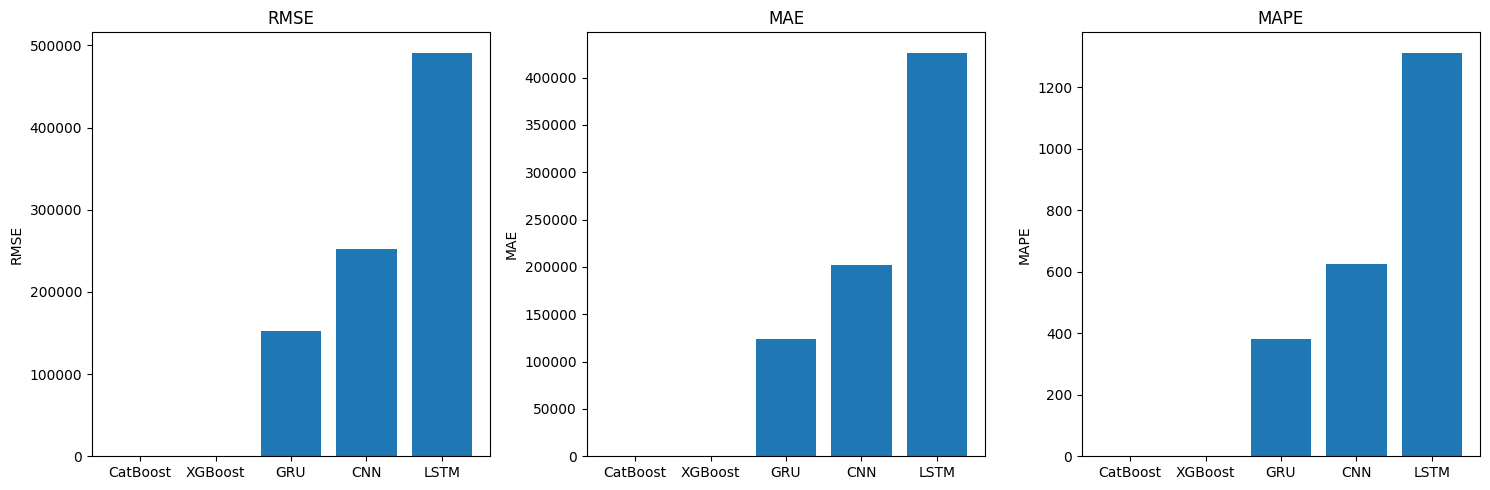

CatBoost:
 RMSE: 19.2612
 MAE: 15.2467
 MAPE: 0.0454
XGBoost:
 RMSE: 22.5784
 MAE: 17.9340
 MAPE: 0.0534
GRU:
 RMSE: 152078.8703
 MAE: 123780.5242
 MAPE: 380.3358
CNN:
 RMSE: 252354.3343
 MAE: 202130.0222
 MAPE: 624.0944
LSTM:
 RMSE: 491256.3687
 MAE: 426526.1777
 MAPE: 1313.6601


In [65]:
# --- Визуализация ---
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, metric in enumerate(["RMSE", "MAE", "MAPE"]):
    model_names = list(results.keys())
    metric_values = [results[name][metric] for name in model_names]
    axes[i].bar(model_names, metric_values)
    axes[i].set_title(metric)
    axes[i].set_ylabel(metric)


plt.tight_layout()
plt.show()

# --- Вывод результатов ---
for name, metrics in results.items():
    print(f"{name}:")
    for metric, value in metrics.items():
        print(f" {metric}: {value:.4f}")